# Quantum Convolution

In [27]:
import cirq
import IPython
import pandas as pd

from pylab import plot, show, axis, subplot, xlabel, ylabel, grid

# visualization tools
import seaborn as sns
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
import IPython
from matplotlib.figure import Figure
from matplotlib.ticker import MaxNLocator

InteractiveShell = IPython.core.interactiveshell.InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
plt.rcParams['figure.figsize'] = [10, 5]

In [236]:
def make_full_adder(a,b,s,g,c):
    yield cirq.X(g)
    yield cirq.CSWAP(a, s, g)
    yield cirq.CSWAP(b, s, g)
    yield cirq.CSWAP(c, s, g)
    yield cirq.CSWAP(s, c, g)
    yield cirq.CSWAP(b, c, g)

def make_adder(A,B,S,G,c):
    for i in range(len(A)-1,-1,-1):
        a = A[i]
        b = B[i]
        s = S[i]
        g = G[i]
        yield make_full_adder(a,b,s,g,c)

def start(A,B,astart,bstart):
    for i in range(len(A)):
        a = A[i]
        b = B[i]
        if astart[i] == "1": yield cirq.X(a)
        if bstart[i] == "1": yield cirq.X(b)
            
def simulate_comp_basis(circuit,n,reps=50000):
    sim = cirq.Simulator()
    results = sim.run(circuit,repetitions=reps).measurements['sum']
    to_binary = np.tile([[2**(n-i-1) for i in range(0,n)]],[reps,1])
    results = np.multiply(results, to_binary).sum(axis=1)
    results = pd.Series(results.flatten()).value_counts()
    results = results/results.sum()
    fig, ax = plt.subplots()
    # take square of probabilities to get amplitudes assuming real amplitudes
    ax.stem(results.index, np.sqrt(results.to_numpy()),basefmt=" ")   
    plt.xlabel('Amplitude')
    plt.ylabel('State')
    plt.xlim([-1,2**n])
    plt.show()
    return results

        

## Check addition works

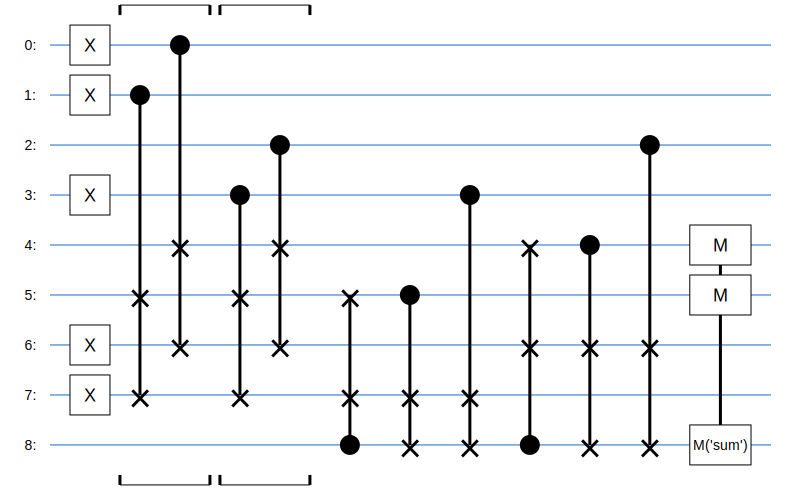

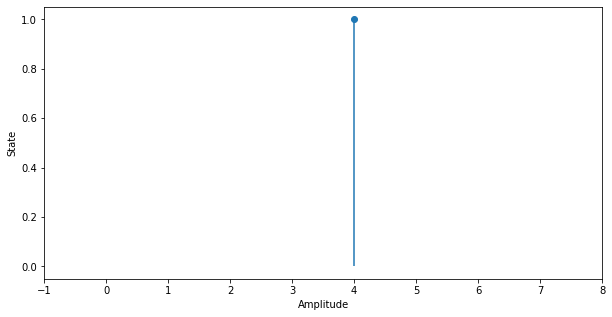

4    1.0
dtype: float64

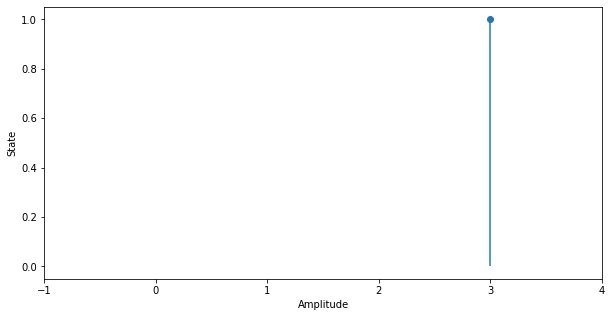

3    1.0
dtype: float64

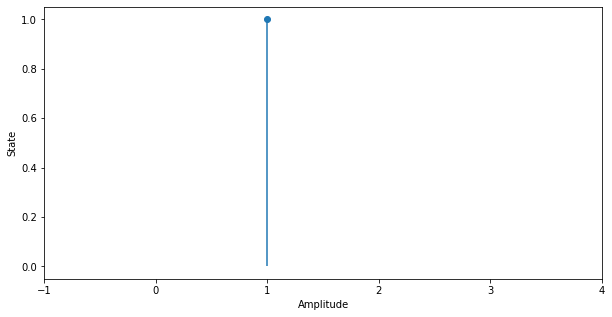

1    1.0
dtype: float64

In [238]:
n = 2
qubits = cirq.LineQubit.range(n*4+1)
a = qubits[0:n]
b = qubits[n:2*n]
s = qubits[2*n:3*n]
g = qubits[3*n:4*n]
c = qubits[4*n]

adder = cirq.Circuit(start(a,b,"11","01"))
adder.append(make_adder(a,b,s,g,c))
adder.append(cirq.measure(*([c]+s), key='sum'))
SVGCircuit(adder)

simulate_comp_basis(adder,n+1)

# plot a
qubits = cirq.LineQubit.range(n*4+1)
a = qubits[0:n]
b = qubits[n:2*n]
s = qubits[2*n:3*n]
g = qubits[3*n:4*n]
c = cirq.Circuit(start(a,b,"11","01"), cirq.measure(*a, key='sum'))
simulate_comp_basis(c,n)
# plot a
qubits = cirq.LineQubit.range(n*4+1)
a = qubits[0:n]
b = qubits[n:2*n]
s = qubits[2*n:3*n]
g = qubits[3*n:4*n]
c = cirq.Circuit(start(a,b,"11","01"), cirq.measure(*b, key='sum'))
simulate_comp_basis(c,n)

## Helper function to create initial signal state

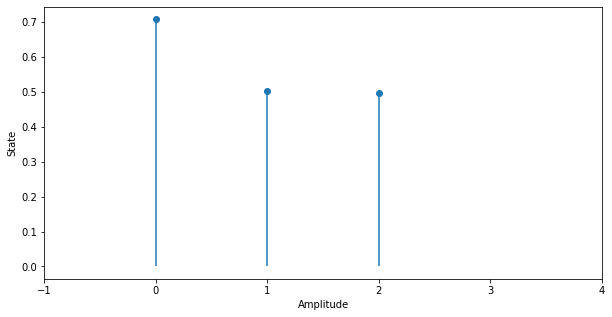

0    0.50140
1    0.25228
2    0.24632
dtype: float64

In [241]:
class ToSignal(cirq.Gate):
    def __init__(self, signal, n):
        super(ToSignal, self)
        assert len(signal) == 2 ** n
        self.n = n
        self.signal = np.array(signal)
        self.signal = self.signal/np.sqrt(np.sum(self.signal ** 2))

    def _num_qubits_(self):
        return self.n

    def _unitary_(self):
        u = np.identity(2 ** self.n)
        u[:,0] = self.signal
        return u

    def _circuit_diagram_info_(self, args):
        return "G"

s = ToSignal([1/np.sqrt(2), 1/2, 1/2, 0], 2)
q = cirq.LineQubit.range(2)
c = cirq.Circuit(s.on(q[0],q[1]), cirq.measure(*q, key='sum'))
simulate_comp_basis(c,2)

<StemContainer object of 3 artists>

(-1.0, 64.0)

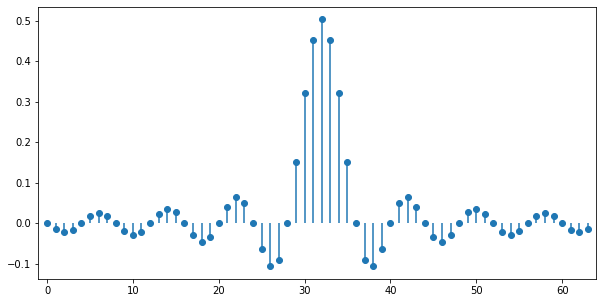

<StemContainer object of 3 artists>

(-1.0, 64.0)

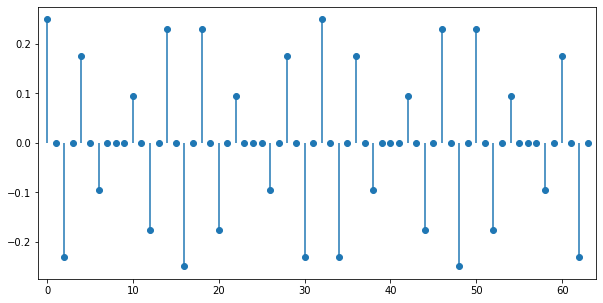

<StemContainer object of 3 artists>

(-1.0, 64.0)

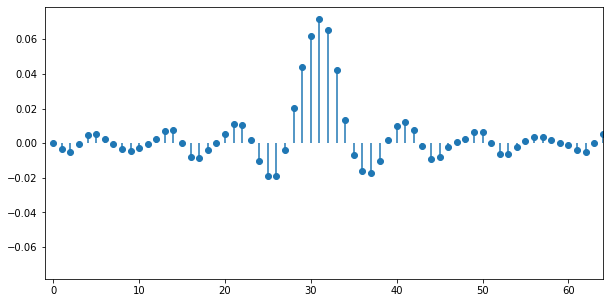

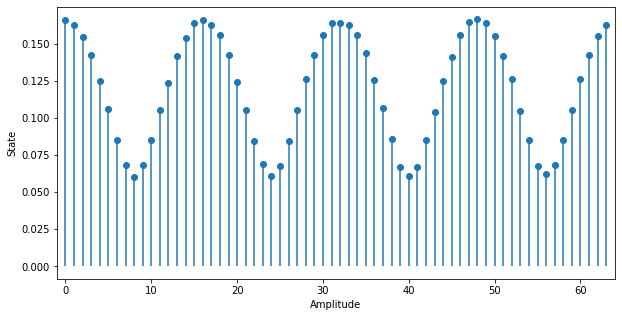

48    0.027646
16    0.027578
0     0.027452
47    0.026958
32    0.026854
        ...   
39    0.004502
56    0.003908
24    0.003740
40    0.003682
8     0.003588
Length: 64, dtype: float64

In [235]:
n = 6

# signal_a = [4,3,2,1]

signal_a = [np.sinc(x/4) for x in range(-2**(n-1),2**(n-1))]
signal_b = [np.cos(x*np.pi/16)*np.cos(x*np.pi/2) for x in range(-2**(n-1),2**(n-1))]

signal_a = np.array(signal_a + [0]*(2**n - len(signal_a)))
signal_b = np.array(signal_b + [0]*(2**n - len(signal_b)))

signal_a = signal_a/np.sqrt(np.sum(signal_a ** 2))
signal_b = signal_b/np.sqrt(np.sum(signal_b ** 2))


fig, ax = plt.subplots()
ax.stem(signal_a,basefmt=" ")
plt.xlim([-1,2**(n)])
plt.show()

fig, ax = plt.subplots()
ax.stem(signal_b,basefmt=" ")
plt.xlim([-1,2**(n)])
plt.show()


# a conv b
qubits = cirq.LineQubit.range(n*4+1)
a = qubits[0:n]
b = qubits[n:2*n]
s = qubits[2*n:3*n]
g = qubits[3*n:4*n]
c = qubits[4*n]


adder = cirq.Circuit(
    ToSignal(signal_a, n).on(*a),
    ToSignal(signal_b, n).on(*b)
)
adder.append(make_adder(a,b,s,g,c))
adder.append(cirq.measure(*(s), key='sum'))

simulate_comp_basis(adder,n,reps=500000)